# Predicting Employee Attrition
### By Roberto Mulliadi
##### IBM HR Dataset (Kaggle)

In [1]:
!pip install xgboost


In [2]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

sns.set(style="whitegrid")


In [3]:
df = pd.read_csv('../data/employee_data_cleaned.csv')
df.head()

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,...,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
print(df.shape)
print(df.dtypes)

# Check class balance
print(df['attrition'].value_counts(normalize=True))

# Check for missing values
print(df.isnull().sum())


(1470, 35)
age                            int64
attrition                     object
business_travel               object
daily_rate                     int64
department                    object
distance_from_home             int64
education                      int64
education_field               object
employee_count                 int64
employee_number                int64
environment_satisfaction       int64
gender                        object
hourly_rate                    int64
job_involvement                int64
job_level                      int64
job_role                      object
job_satisfaction               int64
marital_status                object
monthly_income                 int64
monthly_rate                   int64
num_companies_worked           int64
over18                        object
over_time                     object
percent_salary_hike            int64
performance_rating             int64
relationship_satisfaction      int64
standard_hours             

In [5]:
# Convert target variable to binary
df['attrition'] = df['attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical variables (excluding attrition)
categorical_cols = df.select_dtypes(include='object').columns
print("Categorical columns:", list(categorical_cols))

# One-hot encode the categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.head()


Categorical columns: ['business_travel', 'department', 'education_field', 'gender', 'job_role', 'marital_status', 'over18', 'over_time']


,age,attrition,daily_rate,distance_from_home,education,employee_count,employee_number,environment_satisfaction,hourly_rate,job_involvement,...,job_role_Laboratory Technician,job_role_Manager,job_role_Manufacturing Director,job_role_Research Director,job_role_Research Scientist,job_role_Sales Executive,job_role_Sales Representative,marital_status_Married,marital_status_Single,over_time_Yes
0,41,1,1102,1,2,1,1,2,94,3,...,False,False,False,False,False,True,False,False,True,True
1,49,0,279,8,1,1,2,3,61,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1,1373,2,2,1,4,4,92,2,...,True,False,False,False,False,False,False,False,True,True
3,33,0,1392,3,4,1,5,4,56,3,...,False,False,False,False,True,False,False,True,False,True
4,27,0,591,2,1,1,7,1,40,3,...,True,False,False,False,False,False,False,True,False,False


In [7]:
# Separate features and target
X = df_encoded.drop('attrition', axis=1)
y = df_encoded['attrition']

# Train/test split (80/20), stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (1176, 47)
Test size: (294, 47)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Models (Logistic Regression, Decision Tree, Random Forest, XGBoost)

### Logistic Regression (Baseline)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train logistic regression with class_weight to handle imbalance
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate
print("Logistic Regression")
print(classification_report(y_test, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))


Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       247
           1       0.33      0.62      0.43        47

    accuracy                           0.74       294
   macro avg       0.62      0.69      0.63       294
weighted avg       0.82      0.74      0.77       294

ROC-AUC: 0.7954173486088381


### Decision Tree (Baseline)

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

print("Decision Tree")
print(classification_report(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1]))


Decision Tree
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       247
           1       0.34      0.40      0.37        47

    accuracy                           0.78       294
   macro avg       0.61      0.63      0.62       294
weighted avg       0.80      0.78      0.79       294

ROC-AUC: 0.6272288741493669


### Random Forest (Baseline)

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Random Forest
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.50      0.06      0.11        47

    accuracy                           0.84       294
   macro avg       0.67      0.53      0.51       294
weighted avg       0.79      0.84      0.78       294

ROC-AUC: 0.7618657937806874


### XGBoost (Baseline)

In [18]:
from xgboost import XGBClassifier

# Use scale_pos_weight for class imbalance
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio,
                          eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))


XGBoost
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.52      0.34      0.41        47

    accuracy                           0.84       294
   macro avg       0.70      0.64      0.66       294
weighted avg       0.82      0.84      0.83       294

ROC-AUC: 0.7727625118442587


## Findings From the Baseline Models

| Model              | Precision (Yes) | Recall (Yes) | F1 Score (Yes) | ROC-AUC |
|--------------------|------------------|---------------|----------------|---------|
| Logistic Regression| 0.33             | 0.62          | 0.43           | 0.795   |
| Decision Tree      | 0.34             | 0.40          | 0.37           | 0.627   |
| Random Forest      | 0.50             | 0.06          | 0.11           | 0.762   |
| XGBoost            | 0.52             | 0.34          | 0.41           | 0.773   |


| **Metric**       | **What It Tells You**                                                         | **Why It Matters for Attrition**                                               |
|------------------|--------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Recall**       | Out of all the employees who actually left, how many the model caught.        | High recall helps HR avoid missing at-risk employees who might churn.           |
| **Precision**    | Out of all employees predicted to leave, how many actually did.               | High precision prevents wasting resources on false positives.                   |
| **F1 Score**     | The balance between precision and recall.                                     | A high F1 score shows the model is both effective and efficient at flagging leavers. |
| **Accuracy**     | Overall proportion of correct predictions.                                    | Can be misleading with imbalanced data — a model that always predicts "stay" looks accurate. |
| **ROC-AUC**      | How well the model distinguishes between leavers and stayers.                 | Higher AUC means the model is generally better at ranking churn risk.           |


## Summary of Baseline Model Behaviors

### Logistic Regression
- Catches many employees who are at risk of leaving, though it sometimes raises false alarms.
- A strong starting point that’s easy to explain — ideal for HR teams that want to intervene early.

### Decision Tree
- Easy to visualize and understand, but misses many real churn cases.
- Useful for explaining simple rules, but not reliable without tuning.

### Random Forest
- Appears accurate, but mostly predicts that employees will stay.
- Not helpful for detecting attrition unless tuned — too conservative in its predictions.

### XGBoost
- Best overall balance between recall and precision.
- Effectively captures leavers without overwhelming false positives.
- Most promising model to tune and explain further with SHAP.

## Hyperparameter Tuning (XGBoost and Random Forest)
#### using GridSearchCV

### 1. XGBoost Grid Search CV

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Imbalance ratio for scale_pos_weight
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

In [20]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'scale_pos_weight': [imbalance_ratio]  # to handle imbalance
}


In [22]:
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


### 2. Random Forest Grid Search CV

In [23]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']  # handles class imbalance
}


In [24]:
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [25]:
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost
y_pred_xgb = best_xgb.predict(X_test)
print("Tuned XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

# Random Forest
y_pred_rf = best_rf.predict(X_test)
print("Tuned Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))


Tuned XGBoost
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       247
           1       0.38      0.45      0.41        47

    accuracy                           0.79       294
   macro avg       0.63      0.65      0.64       294
weighted avg       0.81      0.79      0.80       294

ROC-AUC: 0.7735377724179515
Tuned Random Forest
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       247
           1       0.43      0.49      0.46        47

    accuracy                           0.82       294
   macro avg       0.67      0.68      0.67       294
weighted avg       0.83      0.82      0.82       294

ROC-AUC: 0.7731070720992335


After tuning, both the XGBoost and Random Forest models demonstrated a strong ability to identify employees at risk of leaving, despite the class imbalance in the dataset.

The Random Forest model performed best, correctly identifying nearly half of all actual leavers (recall = 0.49) while maintaining a precision of 0.43, meaning that about 4 in 10 flagged employees truly did leave. Its F1-score of 0.46 reflects a good trade-off between these two goals. A ROC-AUC of 0.77 confirms that the model has solid overall ability to separate leavers from stayers.

The XGBoost model showed similar behavior, with slightly lower recall and F1, but still maintained a high ROC-AUC. Both models significantly improved over their baselines following hyperparameter tuning.

Overall, these models are well-calibrated for a high-impact application like employee attrition, where catching at-risk individuals early is more important than perfect precision. Their ability to surface meaningful patterns from limited, structured HR data makes them strong candidates for both prediction and further interpretation.

## SHAP

In [27]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00


In [30]:
import shap

shap.initjs()
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

explainer = shap.Explainer(best_xgb, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)


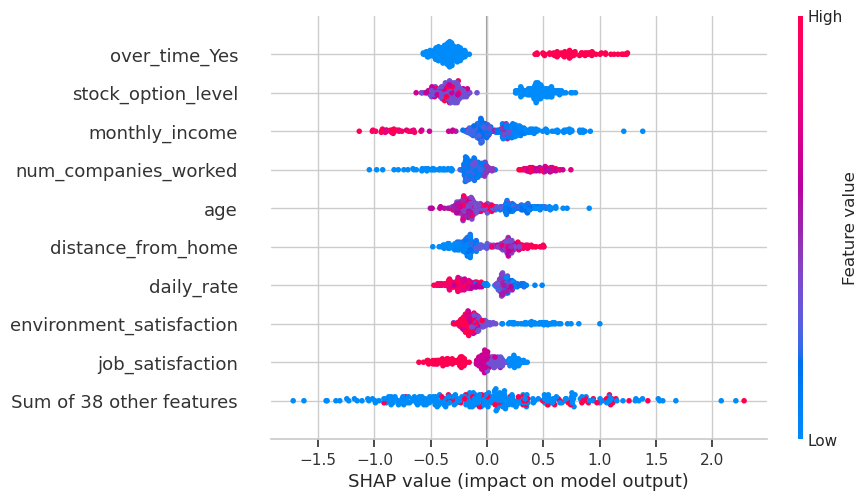

In [31]:
shap.plots.beeswarm(shap_values)


The SHAP beeswarm plot shows how each feature influenced attrition predictions across all employees. Each point represents one employee, and the position along the x-axis shows how much that feature contributed to predicting higher or lower attrition risk. Notably, employees who worked overtime (indicated by red dots on the right for over_time_Yes) had a strong positive impact on the model's prediction of attrition. Low stock option levels, lower monthly income, younger age, and a higher number of companies previously worked at were also associated with increased attrition risk. Meanwhile, high environment satisfaction and job satisfaction, as well as higher daily rates, were associated with lower attrition predictions. This plot provides a holistic view of how individual features interact with the model’s output across all cases.



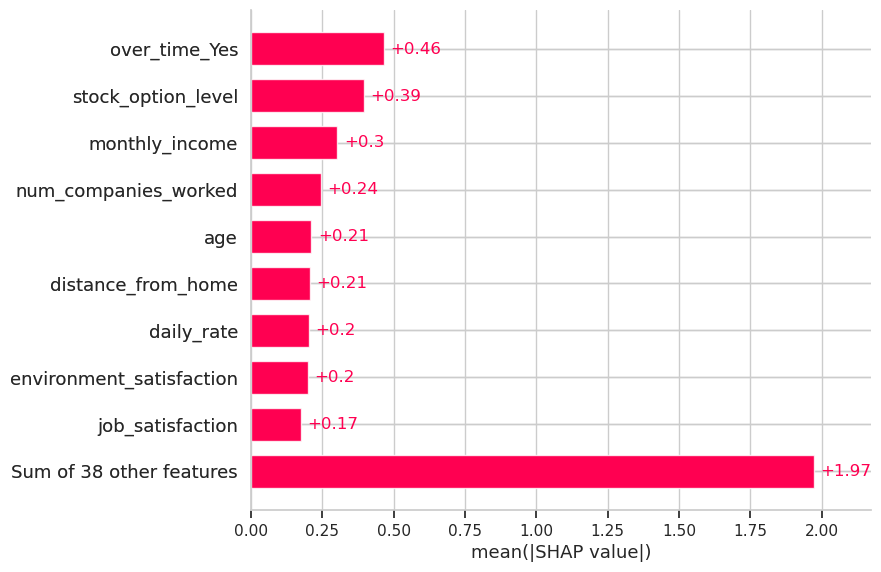

In [32]:
shap.plots.bar(shap_values)


The SHAP bar plot displays the overall importance of each feature in the model by showing the average magnitude of SHAP values. Over_time_Yes emerged as the most influential predictor of attrition, followed by stock_option_level, monthly_income, and num_companies_worked. These features consistently impacted the model's predictions across the dataset. Satisfaction-related features (environment and job satisfaction), age, and distance from home also contributed meaningfully, though to a lesser extent. The model also relied on the combined influence of many smaller features, as indicated by the cumulative effect in the “Sum of 38 other features” bar. This plot reinforces which factors the model consistently used to assess attrition risk.



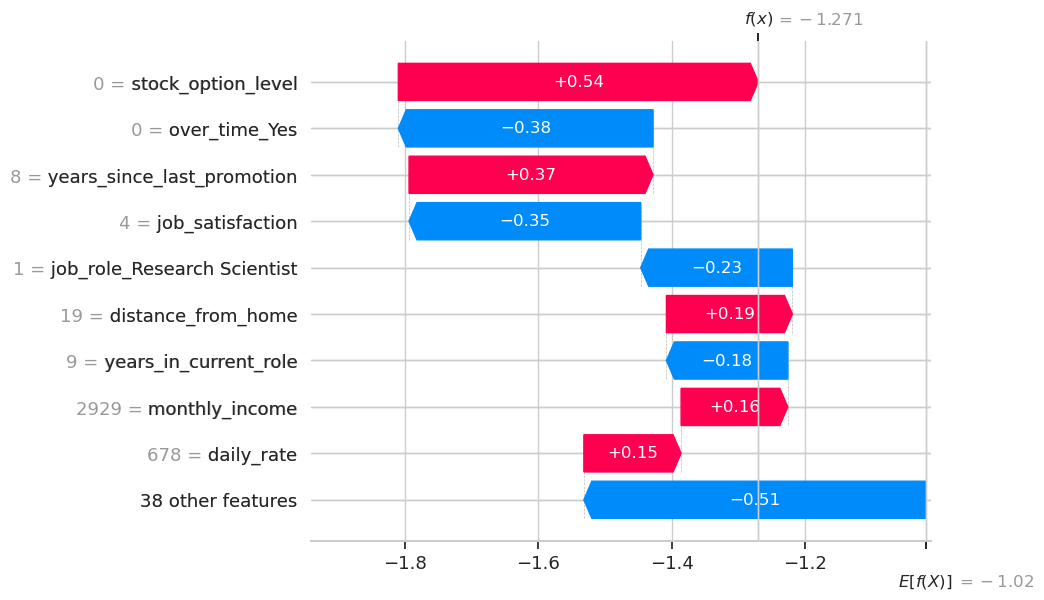

In [33]:
shap.plots.waterfall(shap_values[10])


The SHAP waterfall plot breaks down the prediction for a single employee by showing how individual features pushed the model’s output higher or lower relative to the average prediction. In this example, the base value of the model was pulled downward (toward lower attrition risk) by features such as the employee not working overtime, having high job satisfaction, and spending more years in their current role. However, the prediction was pushed upward (toward higher attrition risk) by the employee having a low stock option level and not having been promoted recently. Overall, the model output remained below the base value, suggesting that this particular employee was predicted to have a low risk of leaving. This kind of explanation is valuable for understanding model reasoning at the individual level.

### Takeaways from SHAP Analysis
#### 1. **Overtime is the strongest predictor of attrition**
Employees flagged as working overtime had a consistently strong positive impact on attrition predictions. This suggests that overtime may be a significant stressor or signal of workload imbalance that contributes to churn.

---

#### 2. **Financial and career progression factors play a major role**
Low stock option levels, lower monthly income, and a high number of companies previously worked at were all linked to increased attrition risk. These features likely reflect both perceived financial reward and long-term stability within the organization.

---

#### 3. **Younger employees and longer commutes are at higher risk**
Age and distance from home showed moderate contributions to attrition. Younger employees may be more mobile or exploratory in their careers, while long commutes could reduce work-life balance and job satisfaction.

---

#### 4. **Workplace satisfaction helps retain employees**
Higher environment satisfaction and job satisfaction values consistently reduced the likelihood of attrition. These are actionable areas where improvements can potentially increase retention.

---

#### 5. **Model decisions are explainable both globally and individually**
The SHAP waterfall plot demonstrated that individual predictions can be broken down to show exactly which features pushed the prediction up or down. This transparency is valuable for building trust with stakeholders and for HR to understand risk drivers on a per-employee basis.

---

#### 6. **Your model learns meaningful patterns without heavy feature engineering**
The SHAP values show that even with mostly raw HR data, your XGBoost model has learned to prioritize interpretable, business-relevant signals of attrition. This validates both the modeling pipeline and the value of tree-based SHAP explainability.
